In [92]:
from pathlib import Path
import sys
project_dir = Path("__file__").resolve().parents[2]
sys.path.insert(0, '{}/temporal_granularity/'.format(project_dir))

import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import pairwise_distances_argmin_min

from sklearn.cluster import KMeans

pd.set_option('display.max_rows', 200)





In [44]:
pv_original = pd.read_csv(
        '{}/data/processed/resources/pv_processed.csv'.format(project_dir))
pv_original['type'] = 'solar'
onshore_original = pd.read_csv(
        '{}/data/processed/resources/onshore_processed.csv'.format(project_dir))
onshore_original['type'] = 'onshore'
offshore_original = pd.read_csv(
        '{}/data/processed/resources/offshore_processed.csv'.format(project_dir))
offshore_original['type'] = 'offshore'
load_original = pd.read_csv(
        '{}/data/processed/demand/load_NG/load_processed_normalised.csv'.format(project_dir))
load_original['type'] = 'load'

total_data = [pv_original, onshore_original, offshore_original, load_original]

In [45]:
data = pd.concat(total_data)
data.head()

,Unnamed: 0,datetime,capacity_factor,type
0,0,1980-01-01 00:00:00,0.0,solar
1,1,1980-01-01 01:00:00,0.0,solar
2,2,1980-01-01 02:00:00,0.0,solar
3,3,1980-01-01 03:00:00,0.0,solar
4,4,1980-01-01 04:00:00,0.0,solar


In [46]:
data = pd.concat(total_data)


data = data.drop('Unnamed: 0', axis=1)

data.set_index('datetime', inplace=True)
data.index = pd.to_datetime(data.index)

data['date'] = data.index.date
data['hour'] = data.index.hour
data['year'] = data.index.year

data = data.pivot_table(index='date', columns=['hour','type'], values='capacity_factor')


data = data.dropna()
data
k_means = KMeans(n_clusters=8)
k_means.fit(data)

y_kmeans = k_means.predict(data)

y_kmeans_df = pd.DataFrame(y_kmeans)
y_kmeans_df = y_kmeans_df.rename(columns={y_kmeans_df.columns[0]: 'cluster'})


y_kmeans_df.groupby("cluster").agg('count')



""
cluster
0
1
2
3
4
5
6
7


In [47]:
count = y_kmeans_df.reset_index().groupby("cluster").count()
to_divide = np.sum(count.iloc[:,0])/365
count.iloc[:,0] = count.iloc[:,0]/to_divide
count.iloc[:,0] = np.ceil(count.iloc[:,0])
count = count.reset_index()
count = count.rename(columns={"index":"number"})
to_remove = 365-np.sum(count.number)
to_remove
count.number.iloc[-1] = count.number.iloc[-1]+to_remove

/Users/b1017579/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
data_w_kmeans = data.copy()
# data_w_kmeans['cluster'] = y_kmeans

data_w_kmeans

closest_data_points, _ = pairwise_distances_argmin_min(k_means.cluster_centers_, data)
eight_medoids_wide = data.iloc[closest_data_points,:]
eight_medoids_wide['number'] = count.number.values

eight_medoids_wide

/Users/b1017579/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


hour               0                                1                         \
type            load offshore onshore solar      load offshore onshore solar   
date                                                                           
2010-08-12  0.233358   0.3670  0.2303   0.0  0.183428   0.3748  0.2319   0.0   
2015-11-25  0.294509   0.6151  0.4233   0.0  0.281278   0.6252  0.4243   0.0   
2012-11-07  0.330134   0.5867  0.4794   0.0  0.335219   0.5694  0.4877   0.0   
2012-07-26  0.254587   0.1383  0.0900   0.0  0.208028   0.1357  0.0887   0.0   
2007-10-02  0.330168   0.3296  0.1628   0.0  0.298222   0.3143  0.1661   0.0   
2011-11-09  0.325004   0.2965  0.2588   0.0  0.311693   0.2999  0.2616   0.0   
2015-08-27  0.188353   0.5847  0.3578   0.0  0.139336   0.5824  0.3766   0.0   
2012-02-18  0.364880   0.6902  0.7050   0.0  0.360766   0.7144  0.7082   0.0   

hour               2           ...    21        22                         \
type            load offshore  ... solar      load offshore onshore solar   
date                           ...                                          
2010-08-12  0.166107   0.3728  ...   0.0  0.409977   0.3966  0.2763   0.0   
2015-11-25  0.254507   0.6201  ...   0.0  0.468145   0.4289  0.2668   0.0   
2012-11-07  0.307408   0.5427  ...   0.0  0.477891   0.7168  0.6170   0.0   
2012-07-26  0.188947   0.1362  ...   0.0  0.421951   0.1331  0.1163   0.0   
2007-10-02  0.308471   0.3056  ...   0.0  0.545691   0.2203  0.1285   0.0   
2011-11-09  0.281244   0.3046  ...   0.0  0.486815   0.4516  0.4050   0.0   
2015-08-27  0.121055   0.5694  ...   0.0  0.358927   0.4547  0.2717   0.0   
2012-02-18  0.322010   0.7362  ...   0.0  0.447328   0.7438  0.5443   0.0   

hour              23                        number  
type            load offshore onshore solar         
date                                                
2010-08-12  0.324033   0.4010  0.2830   0.0   67.0  
2015-11-25  0.369461   0.3820  0.2623   0.0   36.0  
2012-11-07  0.382658   0.7328  0.6334   0.0   27.0  
2012-07-26  0.340074   0.1151  0.1132   0.0   79.0  
2007-10-02  0.432874   0.2156  0.1262   0.0   54.0  
2011-11-09  0.387811   0.4112  0.3701   0.0   34.0  
2015-08-27  0.270789   0.4240  0.2705   0.0   40.0  
2012-02-18  0.391970   0.7537  0.5163   0.0   28.0  

[8 rows x 97 columns]

In [49]:
eight_medoids_wide = eight_medoids_wide.reset_index()
eight_medoids_wide
eight_medoids = eight_medoids_wide.melt(id_vars=["date","number"])
eight_medoids = eight_medoids.sort_values(['date', 'type','hour'])

eight_medoids = eight_medoids.groupby("type", as_index=False).apply(lambda x: x.reset_index())
eight_medoids = eight_medoids.reset_index()
eight_medoids

,level_0,level_1,index,date,number,hour,type,value
0,0,0,4,2007-10-02,54.0,0,load,0.330168
1,0,1,36,2007-10-02,54.0,1,load,0.298222
2,0,2,68,2007-10-02,54.0,2,load,0.308471
3,0,3,100,2007-10-02,54.0,3,load,0.294109
4,0,4,132,2007-10-02,54.0,4,load,0.280181
5,0,5,164,2007-10-02,54.0,5,load,0.284683
6,0,6,196,2007-10-02,54.0,6,load,0.350072
7,0,7,228,2007-10-02,54.0,7,load,0.514511
8,0,8,260,2007-10-02,54.0,8,load,0.625089
9,0,9,292,2007-10-02,54.0,9,load,0.637463


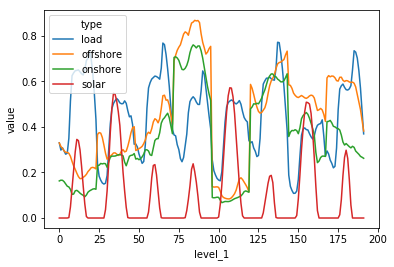

In [50]:
sns.lineplot(data=eight_medoids, x='level_1', y='value', hue='type')


In [51]:
eight_medoids = eight_medoids.drop(columns=['level_0', 'index']).rename(index=str, columns={'level_1':'index'})
eight_medoids.to_csv('/Users/b1017579/Desktop/medoids.csv')


In [52]:
eight_medoids.head()

,index,date,number,hour,type,value
0,0,2007-10-02,54.0,0,load,0.330168
1,1,2007-10-02,54.0,1,load,0.298222
2,2,2007-10-02,54.0,2,load,0.308471
3,3,2007-10-02,54.0,3,load,0.294109
4,4,2007-10-02,54.0,4,load,0.280181


In [53]:
# pd.DataFrame(eight_medoids.groupby(['date', 'type']).apply(lambda x: pd.np.tile(x, reps=int(x.number.iloc[0]))))




In [54]:
eight_medoids_df = eight_medoids.reindex(eight_medoids.index.repeat(eight_medoids.number), index=pd.RangeIndex(0, 100000, 1))
# eight_medoids_df.drop(columns=['level_0', 'level_1', 'index'], inplace=True)
eight_medoids_df.reset_index(drop=True, inplace=True)
eight_medoids_df

,index,date,number,hour,type,value
0,0,2007-10-02,54.0,0,load,0.330168
1,0,2007-10-02,54.0,0,load,0.330168
2,0,2007-10-02,54.0,0,load,0.330168
3,0,2007-10-02,54.0,0,load,0.330168
4,0,2007-10-02,54.0,0,load,0.330168
5,0,2007-10-02,54.0,0,load,0.330168
6,0,2007-10-02,54.0,0,load,0.330168
7,0,2007-10-02,54.0,0,load,0.330168
8,0,2007-10-02,54.0,0,load,0.330168
9,0,2007-10-02,54.0,0,load,0.330168


In [55]:

# eight_medoids_df['date'] = pd.datetime.combine(eight_medoids_df['date'], pd.time(eight_medoids_df['hour']), 1)
eight_medoids_df['datetime'] = pd.to_datetime(eight_medoids_df['date'].apply(str)+' '+eight_medoids_df['hour'].apply(str)+":00:00")
eight_medoids_df


,index,date,number,hour,type,value,datetime
0,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00
1,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00
2,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00
3,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00
4,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00
5,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00
6,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00
7,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00
8,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00
9,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00


In [56]:
eight_medoids_df['ones'] = 1
eight_medoids_df.head()

,index,date,number,hour,type,value,datetime,ones
0,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,1
1,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,1
2,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,1
3,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,1
4,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,1


In [57]:
eight_medoids_df.sort_values(['datetime', 'type'])
eight_medoids_df['ones'] = eight_medoids_df.groupby(['datetime', 'type'])['ones'].transform(lambda x: x.cumsum())
eight_medoids_df
# eight_medoids_index = eight_medoids_df.groupby(['datetime', 'value']).apply(lambda x: x.reset_index())
# eight_medoids_index = eight_medoids_index.drop(columns=['level_0','index', 'date'])
# eight_medoids_index = eight_medoids_index.reset_index()


,index,date,number,hour,type,value,datetime,ones
0,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,1
1,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,2
2,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,3
3,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,4
4,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,5
5,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,6
6,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,7
7,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,8
8,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,9
9,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,10


In [58]:
eight_medoids_df.sort_values(['date','ones'])
eight_medoids_df['shifted_date']  = pd.to_datetime("2016-01-01")
eight_medoids_df.head()

,index,date,number,hour,type,value,datetime,ones,shifted_date
0,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,1,2016-01-01
1,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,2,2016-01-01
2,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,3,2016-01-01
3,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,4,2016-01-01
4,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,5,2016-01-01


In [59]:
eight_medoids_df['ones_2'] = 1
eight_medoids_df['ones_cumsum'] = eight_medoids_df.groupby(['type', 'date'])['ones_2'].transform(lambda x: x.cumsum())
eight_medoids_df.sort_values(['date','ones_cumsum'])

,index,date,number,hour,type,value,datetime,ones,shifted_date,ones_2,ones_cumsum
0,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,1,2016-01-01,1,1
8760,0,2007-10-02,54.0,0,offshore,0.329600,2007-10-02 00:00:00,1,2016-01-01,1,1
17520,0,2007-10-02,54.0,0,onshore,0.162800,2007-10-02 00:00:00,1,2016-01-01,1,1
26280,0,2007-10-02,54.0,0,solar,0.000000,2007-10-02 00:00:00,1,2016-01-01,1,1
1,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,2,2016-01-01,1,2
8761,0,2007-10-02,54.0,0,offshore,0.329600,2007-10-02 00:00:00,2,2016-01-01,1,2
17521,0,2007-10-02,54.0,0,onshore,0.162800,2007-10-02 00:00:00,2,2016-01-01,1,2
26281,0,2007-10-02,54.0,0,solar,0.000000,2007-10-02 00:00:00,2,2016-01-01,1,2
2,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,3,2016-01-01,1,3
8762,0,2007-10-02,54.0,0,offshore,0.329600,2007-10-02 00:00:00,3,2016-01-01,1,3


In [60]:
eight_medoids_df['simulated_date'] = eight_medoids_df['shifted_date'] + pd.to_timedelta(eight_medoids_df['ones'], unit="D")  + pd.to_timedelta(eight_medoids_df['hour'], unit="H")
eight_medoids_df



,index,date,number,hour,type,value,datetime,ones,shifted_date,ones_2,ones_cumsum,simulated_date
0,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,1,2016-01-01,1,1,2016-01-02 00:00:00
1,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,2,2016-01-01,1,2,2016-01-03 00:00:00
2,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,3,2016-01-01,1,3,2016-01-04 00:00:00
3,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,4,2016-01-01,1,4,2016-01-05 00:00:00
4,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,5,2016-01-01,1,5,2016-01-06 00:00:00
5,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,6,2016-01-01,1,6,2016-01-07 00:00:00
6,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,7,2016-01-01,1,7,2016-01-08 00:00:00
7,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,8,2016-01-01,1,8,2016-01-09 00:00:00
8,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,9,2016-01-01,1,9,2016-01-10 00:00:00
9,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,10,2016-01-01,1,10,2016-01-11 00:00:00


In [61]:
eight_medoids_df[(eight_medoids_df.simulated_date>"2016-01-02") & (eight_medoids_df.simulated_date<"2016-01-08")].sort_values(['simulated_date', 'type'])



,index,date,number,hour,type,value,datetime,ones,shifted_date,ones_2,ones_cumsum,simulated_date
54,1,2007-10-02,54.0,1,load,0.298222,2007-10-02 01:00:00,1,2016-01-01,1,55,2016-01-02 01:00:00
1363,25,2010-08-12,67.0,1,load,0.183428,2010-08-12 01:00:00,1,2016-01-01,1,68,2016-01-02 01:00:00
2938,49,2011-11-09,34.0,1,load,0.311693,2011-11-09 01:00:00,1,2016-01-01,1,35,2016-01-02 01:00:00
3748,73,2012-02-18,28.0,1,load,0.360766,2012-02-18 01:00:00,1,2016-01-01,1,29,2016-01-02 01:00:00
4471,97,2012-07-26,79.0,1,load,0.208028,2012-07-26 01:00:00,1,2016-01-01,1,80,2016-01-02 01:00:00
6315,121,2012-11-07,27.0,1,load,0.335219,2012-11-07 01:00:00,1,2016-01-01,1,28,2016-01-02 01:00:00
6976,145,2015-08-27,40.0,1,load,0.139336,2015-08-27 01:00:00,1,2016-01-01,1,41,2016-01-02 01:00:00
7932,169,2015-11-25,36.0,1,load,0.281278,2015-11-25 01:00:00,1,2016-01-01,1,37,2016-01-02 01:00:00
8814,1,2007-10-02,54.0,1,offshore,0.314300,2007-10-02 01:00:00,1,2016-01-01,1,55,2016-01-02 01:00:00
10123,25,2010-08-12,67.0,1,offshore,0.374800,2010-08-12 01:00:00,1,2016-01-01,1,68,2016-01-02 01:00:00


In [75]:
pd.unique(eight_medoids_df.number)

array([54., 67., 34., 28., 79., 27., 40., 36.])

In [89]:
eight_medoids_df_cluster = eight_medoids_df.copy()
eight_medoids_df_cluster['ones_3'] = 1
# eight_medoids_df_cluster['clusters_difference_days'] = eight_medoids_df_cluster.groupby(['type','simulated_date'])['number'].transform(lambda x: x.cumsum())
# eight_medoids_df_cluster['clusters_difference_days'] = eight_medoids_df_cluster.groupby(['type','simulated_date'])['number'].transform(lambda x: x.rolling(min_periods=1, window=5000).sum())
eight_medoids_df_cluster['number_negative'] = eight_medoids_df_cluster['number'].replace({54:0, 67:54, 34:67, 28:34, 79:28, 27:79, 40:27, 36:40})
eight_medoids_df_cluster['clusters_difference_days'] = eight_medoids_df_cluster.groupby(['type','simulated_date'])['number_negative'].transform(lambda x: x.cumsum())

eight_medoids_df_cluster



,index,date,number,hour,type,value,datetime,ones,shifted_date,ones_2,ones_cumsum,simulated_date,ones_3,number_negative,clusters_difference_days
0,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,1,2016-01-01,1,1,2016-01-02 00:00:00,1,0.0,0.0
1,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,2,2016-01-01,1,2,2016-01-03 00:00:00,1,0.0,0.0
2,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,3,2016-01-01,1,3,2016-01-04 00:00:00,1,0.0,0.0
3,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,4,2016-01-01,1,4,2016-01-05 00:00:00,1,0.0,0.0
4,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,5,2016-01-01,1,5,2016-01-06 00:00:00,1,0.0,0.0
5,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,6,2016-01-01,1,6,2016-01-07 00:00:00,1,0.0,0.0
6,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,7,2016-01-01,1,7,2016-01-08 00:00:00,1,0.0,0.0
7,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,8,2016-01-01,1,8,2016-01-09 00:00:00,1,0.0,0.0
8,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,9,2016-01-01,1,9,2016-01-10 00:00:00,1,0.0,0.0
9,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,10,2016-01-01,1,10,2016-01-11 00:00:00,1,0.0,0.0


In [90]:
eight_medoids_df_cluster['simulated_date'] = eight_medoids_df_cluster['simulated_date'] + pd.to_timedelta(eight_medoids_df_cluster['clusters_difference_days'], unit="D")

# eight_medoids_df_cluster[['simulated_date','type','value']].sort_values(['simulated_date','type']).to_csv('~/Desktop/cluster_test.csv')

eight_medoids_df_cluster

,index,date,number,hour,type,value,datetime,ones,shifted_date,ones_2,ones_cumsum,simulated_date,ones_3,number_negative,clusters_difference_days
0,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,1,2016-01-01,1,1,2016-01-02 00:00:00,1,0.0,0.0
1,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,2,2016-01-01,1,2,2016-01-03 00:00:00,1,0.0,0.0
2,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,3,2016-01-01,1,3,2016-01-04 00:00:00,1,0.0,0.0
3,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,4,2016-01-01,1,4,2016-01-05 00:00:00,1,0.0,0.0
4,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,5,2016-01-01,1,5,2016-01-06 00:00:00,1,0.0,0.0
5,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,6,2016-01-01,1,6,2016-01-07 00:00:00,1,0.0,0.0
6,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,7,2016-01-01,1,7,2016-01-08 00:00:00,1,0.0,0.0
7,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,8,2016-01-01,1,8,2016-01-09 00:00:00,1,0.0,0.0
8,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,9,2016-01-01,1,9,2016-01-10 00:00:00,1,0.0,0.0
9,0,2007-10-02,54.0,0,load,0.330168,2007-10-02 00:00:00,10,2016-01-01,1,10,2016-01-11 00:00:00,1,0.0,0.0


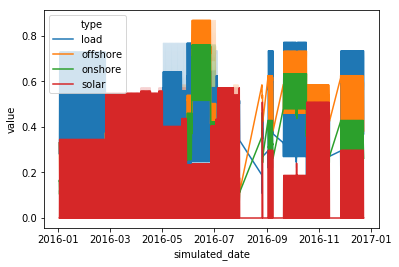

In [91]:
sns.lineplot(data=eight_medoids_df_cluster, x='simulated_date', y='value', hue='type')


In [22]:
eight_medoids_df['timedelta'] = eight_medoids_df.datetime + pd.to_timedelta(eight_medoids_df.ones, unit="D")
eight_medoids_df.head()

,index,date,number,hour,type,value,datetime,ones,timedelta
0,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,1,2007-10-03
1,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,2,2007-10-04
2,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,3,2007-10-05
3,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,4,2007-10-06
4,0,2007-10-02,54.0,0,load,0.330168,2007-10-02,5,2007-10-07


/Users/b1017579/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


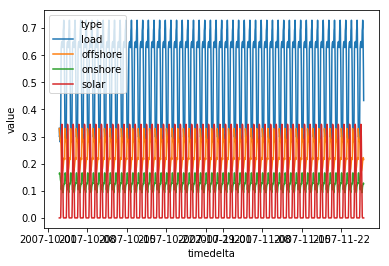

In [24]:
sns.lineplot(data=eight_medoids_df[(eight_medoids_df.timedelta>"2007") & (eight_medoids_df.timedelta<"2008")], x='timedelta', y='value', hue='type')

In [ ]:
eight_medoids_df['sorted'] = eight_medoids_df['ones']+eight_medoids_df['hour']
# eight_medoids_df['sorted'] = pd.to_numeric(eight_medoids_df['sorted'])
eight_medoids_df

In [ ]:
sns.lineplot(data=eight_medoids_df, x='sorted', y='value', hue='type')

In [ ]:
eight_medoids_index.sort_values(['date', 'level_1', 'hour'])

In [ ]:
sns.lineplot(data=eight_medoids_index, x='level_1', y='value', hue='type')

In [ ]:
eight_medoids_index['diff'] = np.linspace(0.083, 8752.5, 20 * model.market_time_splices)

In [ ]:
sns.lineplot(data=eight_medoids_index, x=)

In [ ]:
# eight_medoids.to_csv("/Users/b1017579/Documents/PhD/Projects/10. ELECSIM/elecsim/data/processed/multi_day_data/8_medoids.csv")

In [ ]:
r_data = pd.read_csv('/Users/b1017579/Desktop/sims.csv')

In [ ]:
r_data.head()

In [ ]:
r_data['datetime'] = pd.to_datetime(r_data['date'].apply(str)+' '+r_data['hour'].apply(str)+":00:00")
r_data.groupby(['date','type'])[''].transform()

In [ ]:
sns.lineplot(data = r_data, x="datetime", y="value", hue="type", size="date")